In [1]:
import ast
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer, CLIPModel, CLIPProcessor
from tqdm import tqdm

/home/ptyagi/miniconda3/envs/thesis_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLPForCombinedPredictions(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels):
        super(MLPForCombinedPredictions, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels),
            nn.Softmax(dim=-1)  
        )
    
    def forward(self, x):
        return self.mlp(x)

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data: DataFrame containing the data.
        """
        self.data = data
        self.label_order = ['fear', 'disgust', 'joy', 'surprise', 'sadness', 'anger']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def extract_probs(column):
            prob_dict = dict(ast.literal_eval(row[column]))
            return [prob_dict[label] for label in self.label_order]

        image_probs = torch.tensor(extract_probs('clip_predictions'), dtype=torch.float32)
        text_probs = torch.tensor(extract_probs('mapped_predictions'), dtype=torch.float32)
        labels = torch.tensor(extract_probs('averaged_predictions'), dtype=torch.float32)

        combined_features = torch.cat((image_probs, text_probs), dim=0)
        return combined_features, labels

In [4]:
def train_mlp(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(torch.log(predictions), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_kl_div = 0.0
    total_cosine_sim = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)

            total_kl_div += F.kl_div(torch.log(predictions), labels, reduction='batchmean').item() * len(features)
            total_cosine_sim += F.cosine_similarity(predictions, labels, dim=-1).mean().item() * len(features)
            total_mse += F.mse_loss(predictions, labels, reduction='mean').item() * len(features)
            num_samples += len(features)

    avg_kl_div = total_kl_div / num_samples
    avg_cosine_sim = total_cosine_sim / num_samples
    avg_mse = total_mse / num_samples

    return avg_kl_div, avg_cosine_sim, avg_mse

def plot_cosine_similarity_kde(predictions, labels):
    """
    Compute and visualize the distribution of cosine similarities using a KDE plot.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
    """
    similarities = F.cosine_similarity(predictions, labels, dim=-1).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.kdeplot(similarities, fill=True, color="blue")
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Similarity')
    plt.legend()
    plt.show()



In [ ]:
def plot_label_wise_heatmap(predictions, labels, label_order):
    """
    Plot a heatmap comparing average predicted vs actual probabilities for each label.
    """
    avg_pred = predictions.mean(dim=0).detach().cpu().numpy()
    avg_label = labels.mean(dim=0).cpu().numpy()

    heatmap_data = np.vstack([avg_label, avg_pred])
    labels = ["True", "Predicted"]

    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=label_order, yticklabels=labels)
    plt.title("Label-Wise Average Probabilities")
    plt.xlabel("Labels")
    plt.ylabel("Distribution")
    plt.show()

In [ ]:
def print_random_predictions(predictions, labels, label_order, num_samples=5):
    """
    Print a few random predictions and their corresponding true labels.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
        label_order: List of labels in the correct order.
        num_samples: Number of random samples to display.
    """
    predictions = predictions.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    indices = random.sample(range(len(predictions)), num_samples)

    for idx in indices:
        print(f"Sample {idx + 1}")
        print("True Labels:")
        for label, prob in zip(label_order, labels[idx]):
            print(f"  {label}: {prob:.4f}")
        print("Predicted Labels:")
        for label, prob in zip(label_order, predictions[idx]):
            print(f"  {label}: {prob:.4f}")
        print("-" * 40)

Epoch 1/5, Train Loss: 0.4361, Validation KL Divergence: 0.3571
Epoch 2/5, Train Loss: 0.3670, Validation KL Divergence: 0.3418
Epoch 3/5, Train Loss: 0.3536, Validation KL Divergence: 0.3389
Epoch 4/5, Train Loss: 0.3511, Validation KL Divergence: 0.3410
Epoch 5/5, Train Loss: 0.3467, Validation KL Divergence: 0.3393
Test KL Divergence: 0.3337, Cosine Similarity: 0.8006, MSE: 0.0224


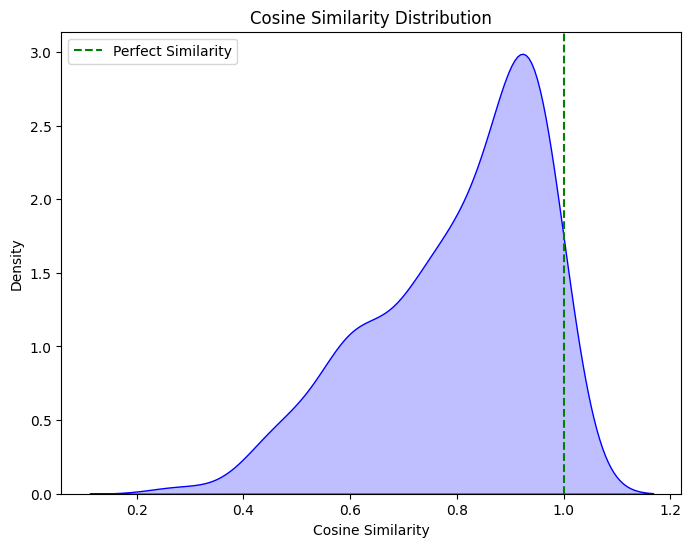

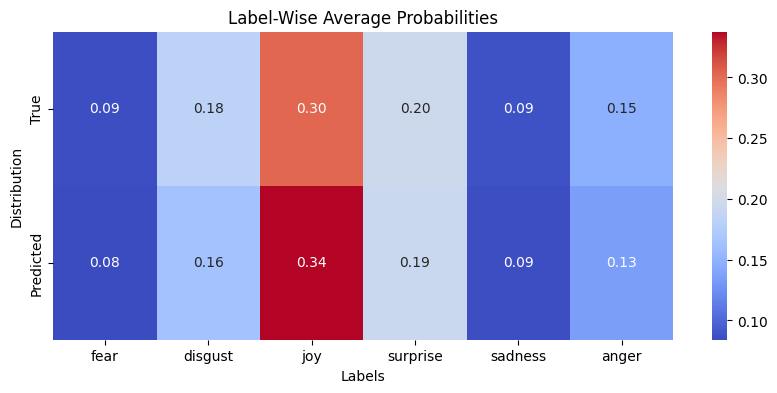

In [7]:
file_path = "/work/ptyagi/masterthesis/data/predictions/averaged_predictions.csv" 

data = pd.read_csv(file_path)
    
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

train_dataset = EmotionDataset(train_data)
val_dataset = EmotionDataset(val_data)
test_dataset = EmotionDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_labels = 6  
input_dim = num_labels * 2  
hidden_dim = 128

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = MLPForCombinedPredictions(input_dim=input_dim, hidden_dim=hidden_dim, num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.KLDivLoss(reduction="batchmean")

epochs = 5
for epoch in range(epochs):
    train_loss = train_mlp(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_model(model, val_loader, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation KL Divergence: {val_loss[0]:.4f}")

avg_kl_div, avg_cosine_sim, avg_mse = evaluate_model(model, test_loader, device)
print(f"Test KL Divergence: {avg_kl_div:.4f}, Cosine Similarity: {avg_cosine_sim:.4f}, MSE: {avg_mse:.4f}")

all_predictions = []
all_labels = []

for features, labels in test_loader:
    features, labels = features.to(device), labels.to(device)
    predictions = model(features)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

plot_cosine_similarity_kde(all_predictions, all_labels)
plot_label_wise_heatmap(all_predictions, all_labels, train_dataset.label_order)


In [11]:
print_random_predictions(all_predictions, all_labels, train_dataset.label_order, num_samples=1)

Sample 74
True Labels:
  fear: 0.0604
  disgust: 0.0631
  joy: 0.6407
  surprise: 0.0540
  sadness: 0.1112
  anger: 0.0706
Predicted Labels:
  fear: 0.0597
  disgust: 0.1106
  joy: 0.4678
  surprise: 0.2033
  sadness: 0.0686
  anger: 0.0900
----------------------------------------


In [2]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [3]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_labels, hidden_dim=512):
        
        super(MultiModalClassifier, self).__init__()
        
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.text_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-large-emotion-latest")

        clip_feature_dim = self.clip_model.config.projection_dim  
        text_feature_dim = self.text_model.config.hidden_size
        combined_dim = clip_feature_dim + text_feature_dim

        self.mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        image_features = self.clip_model.get_image_features(image)

        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :] 

        combined_features = torch.cat([image_features, text_features], dim=-1)

        logits = self.mlp(combined_features)
        return logits

In [4]:
model = MultiModalClassifier(num_labels=6)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-large-emotion-latest and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model

MultiModalClassifier(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=7

In [6]:
class MultiModalDataset(Dataset):
    def __init__(self, data=None, csv_path=None, image_dir=None, label_col=None, image_col=None, text_col=None, clip_processor=None, roberta_tokenizer=None, max_length=512):
        if data is not None:
            self.data = data
        elif csv_path is not None:
            self.data = pd.read_csv(csv_path)
        else:
            raise ValueError("Either `data` or `csv_path` must be provided.")

        self.image_dir = image_dir
        self.label_col = label_col
        self.image_col = image_col
        self.text_col = text_col
        self.clip_processor = clip_processor
        self.tokenizer = roberta_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_filename = self.data.iloc[idx][self.image_col]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        image = self.clip_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        text = self.data.iloc[idx][self.text_col]
        text_inputs = self.tokenizer(
            text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

        label_tuples = eval(self.data.iloc[idx][self.label_col])  
        label_probs = [prob for _, prob in label_tuples]  
        label_tensor = torch.tensor(label_probs, dtype=torch.float)

        return {
            "image": image,
            "input_ids": text_inputs["input_ids"].squeeze(0),
            "attention_mask": text_inputs["attention_mask"].squeeze(0),
            "labels": label_tensor,
        }

In [7]:
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-large-emotion-latest")

csv_path = "/work/ptyagi/masterthesis/data/predictions/averaged_predictions.csv"

image_dir = "/work/ptyagi/ClimateVisions/Images/2019/02_February"

label_col = "averaged_predictions" 

text_col = "tweet_text" 

image_col = "matched_filename"

data = pd.read_csv(csv_path)

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

train_dataset = MultiModalDataset(
    data=train_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

val_dataset = MultiModalDataset(
    data=val_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

test_dataset = MultiModalDataset(
    data=test_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

criterion = nn.KLDivLoss(reduction="batchmean") 
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/home/ptyagi/miniconda3/envs/thesis_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
def evaluate_model(model, dataloader, device):

    model.eval()
    total_kl_div = 0.0
    total_cosine_sim = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            predictions = model(images, input_ids, attention_mask)
            predictions = torch.softmax(predictions, dim=-1)

            total_kl_div += F.kl_div(torch.log(predictions), labels, reduction='batchmean').item() * len(images)
            total_cosine_sim += F.cosine_similarity(predictions, labels, dim=-1).mean().item() * len(images)
            total_mse += F.mse_loss(predictions, labels, reduction='mean').item() * len(images)
            num_samples += len(images)

    avg_kl_div = total_kl_div / num_samples
    avg_cosine_sim = total_cosine_sim / num_samples
    avg_mse = total_mse / num_samples

    return avg_kl_div, avg_cosine_sim, avg_mse

In [10]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, device, save_path=None):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")

        for batch in progress_bar:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(torch.log_softmax(outputs, dim=-1), labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

        val_kl_div, val_cosine_sim, val_mse = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch + 1}/{epochs} - Validation Metrics - KL Div: {val_kl_div:.4f}, Cosine Sim: {val_cosine_sim:.4f}, MSE: {val_mse:.4f}")

        if val_kl_div < best_val_loss:
            best_val_loss = val_kl_div
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"Model saved at {save_path}")

    test_kl_div, test_cosine_sim, test_mse = evaluate_model(model, test_loader, device)
    print(f"Test Metrics - KL Div: {test_kl_div:.4f}, Cosine Sim: {test_cosine_sim:.4f}, MSE: {test_mse:.4f}")
    

In [ ]:
def save_initial_weights(model):
    initial_weights = {
        "clip": {name: param.clone() for name, param in model.clip_model.named_parameters()},
        "roberta": {name: param.clone() for name, param in model.text_model.named_parameters()}
    }
    return initial_weights

def compare_weights(initial_weights, model):
    weight_differences = {
        "clip": {name: (param - initial_weights["clip"][name]).norm().item()
                for name, param in model.clip_model.named_parameters()},
        "roberta": {name: (param - initial_weights["roberta"][name]).norm().item()
                    for name, param in model.text_model.named_parameters()}
    }
    return weight_differences

def plot_weight_updates(weight_differences, model_name):

    updates = list(weight_differences.values())
    plt.figure(figsize=(8, 6))
    plt.hist(updates, bins=50, alpha=0.7, color="blue")
    plt.title(f"Weight Updates for {model_name}")
    plt.xlabel("Weight Update Magnitude (L2 Norm)")
    plt.ylabel("Frequency")
    plt.show()

Epoch 1/2 - Training: 100%|██████████| 147/147 [02:29<00:00,  1.02s/it, loss=0.34] 


Epoch 1/2 - Training Loss: 0.3633
Epoch 1/2 - Validation Metrics - KL Div: 0.3320, Cosine Sim: 0.8237, MSE: 0.0216
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model.pt


Epoch 2/2 - Training: 100%|██████████| 147/147 [02:31<00:00,  1.03s/it, loss=0.152]


Epoch 2/2 - Training Loss: 0.2888
Epoch 2/2 - Validation Metrics - KL Div: 0.3377, Cosine Sim: 0.8205, MSE: 0.0219
Test Metrics - KL Div: 0.3522, Cosine Sim: 0.7924, MSE: 0.0236


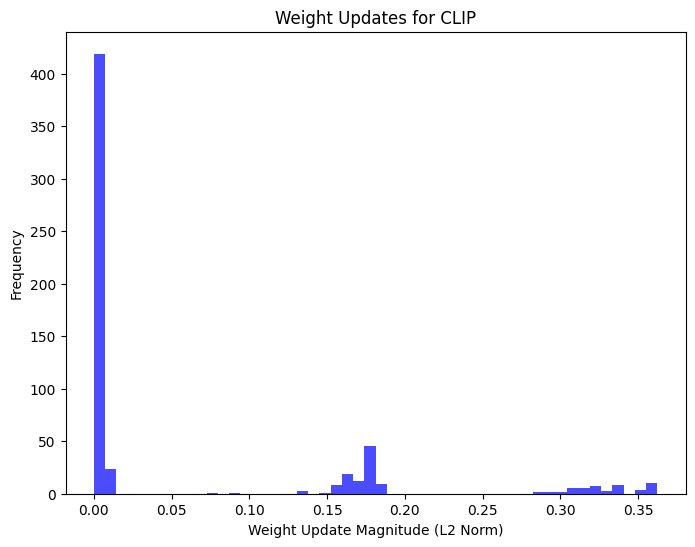

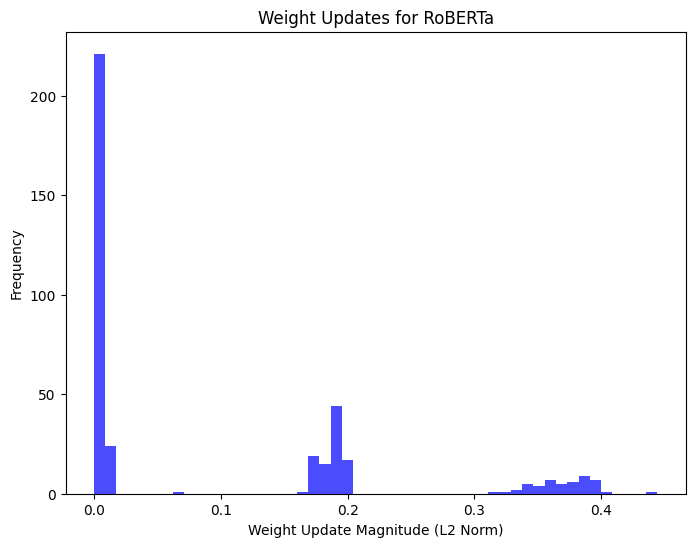

In [11]:
model.to(device)
# initial_weights = save_initial_weights(model)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=2, device=device, save_path=save_path)

# weight_differences = compare_weights(initial_weights, model)

# plot_weight_updates(weight_differences["clip"], "CLIP")
# plot_weight_updates(weight_differences["roberta"], "RoBERTa")

In [13]:
def load_model(model_class, save_path, device, num_labels):

    model = model_class(num_labels=num_labels)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def print_random_predictions(predictions, labels, label_order, num_samples=2):

    predictions = predictions.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    indices = random.sample(range(len(predictions)), num_samples)

    for idx in indices:
        print(f"Sample {idx + 1}")
        print("True Labels:")
        for label, prob in zip(label_order, labels[idx]):
            print(f"  {label}: {prob:.4f}")
        print("Predicted Labels:")
        for label, prob in zip(label_order, predictions[idx]):
            print(f"  {label}: {prob:.4f}")
        print("-" * 40)

In [17]:
label_order = ["fear", "disgust", "joy", "surprise", "sadness", "anger"] 
save_path = "/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model.pt"

# model = load_model(MultiModalClassifier, save_path, device, num_labels=len(label_order))

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

batch = next(iter(test_loader))
images = batch["image"].to(device)
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)

with torch.no_grad():
    outputs = model(images, input_ids, attention_mask)
    predictions = torch.softmax(outputs, dim=-1) 

print_random_predictions(predictions, labels, label_order, num_samples=1)

Sample 7
True Labels:
  fear: 0.0336
  disgust: 0.2031
  joy: 0.4019
  surprise: 0.2905
  sadness: 0.0097
  anger: 0.0612
Predicted Labels:
  fear: 0.0616
  disgust: 0.1277
  joy: 0.3026
  surprise: 0.3195
  sadness: 0.0983
  anger: 0.0903
----------------------------------------


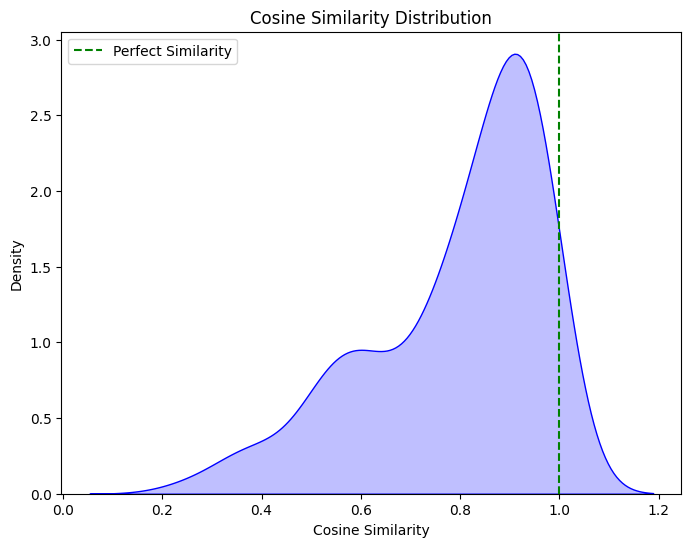

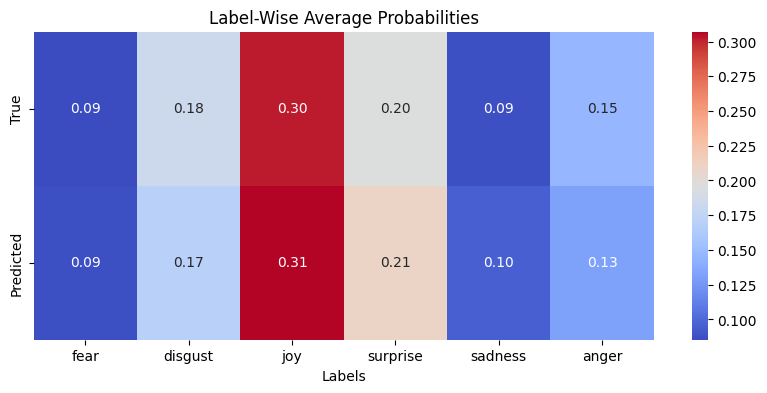

In [18]:
def evaluate_on_test_set(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(images, input_ids, attention_mask)
            predictions = torch.softmax(outputs, dim=-1)

            all_predictions.append(predictions)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_predictions, all_labels

def plot_cosine_similarity_kde(predictions, labels):

    similarities = F.cosine_similarity(predictions, labels, dim=-1).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.kdeplot(similarities, fill=True, color="blue")
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Similarity')
    plt.legend()
    plt.show()

def plot_label_wise_heatmap(predictions, labels, label_order):

    avg_pred = predictions.mean(dim=0).detach().cpu().numpy()
    avg_label = labels.mean(dim=0).cpu().numpy()

    heatmap_data = np.vstack([avg_label, avg_pred])
    row_labels = ["True", "Predicted"]

    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=label_order, yticklabels=row_labels)
    plt.title("Label-Wise Average Probabilities")
    plt.xlabel("Labels")
    plt.ylabel("")
    plt.show()


all_predictions, all_labels = evaluate_on_test_set(model, test_loader, device)

plot_cosine_similarity_kde(all_predictions, all_labels)

plot_label_wise_heatmap(all_predictions, all_labels, label_order)